<center><h1>Evaluation of the MLM models</h1></center>

## Import librairies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import tensorflow as tf
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

## Import Datasets

In [ ]:
df_bert = pd.read_excel("../../Datasets/bert-base-uncased.xlsx")
df_roberta = pd.read_excel("../../Datasets/roberta-base_pred.xlsx")
df_distilroberta = pd.read_excel("../../Datasets/distilroberta-base_pred.xlsx")
df_albert = pd.read_excel("../../Datasets/albert-base_pred.xlsx")
df_ditilbert = pd.read_excel("../../Datasets/distilbert-base-uncased_pred_ngram.xlsx")

## Evaluation function

### Accuracy

### Pseudo-log-likelihood (PLL) and Perplexity

#### Explanation :

##### PLL

Pseudo-log-likelihood (PLL) is a scoring method used in language modeling, taken from the pdf here : https://aclanthology.org/2020.acl-main.240.pdf. 

It calculates the probability of a word given its previous words in a sentence, by treating the remaining words as a set of distractors.


The PLL score is calculated as follows:
1.
For each word w in the sentence, PLL computes its log probability given the preceding words. This is done by taking the sum of the log probabilities of the word w given each of the preceding words in the sentence.
2.
The PLL score is then computed as the sum of these log probabilities, divided by the number of words in the sentence minus 1. The minus 1 is used to exclude the last word in the sentence, which has no succeeding words.


//
Lower PLL values indicate that the model assigns higher probabilities to the true tokens in the input text, which means that the model is better at predicting the masked tokens.

##### Perplexity 

Perplexity is a measure of how well a probability distribution or model predicts a sample. 
It is calculated as the exponential of the cross-entropy loss between the predicted token probabilities and the true tokens. 


//
Lower perplexity values indicate that the model assigns higher probabilities to the true tokens in the input text, which means that the model is better at predicting the next token in a sequence.

In [1]:
import tensorflow as tf
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

def compute_pll(sentences, model_name= 'bert-base-uncased'):
    # Gett model n tokenizer 
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForMaskedLM.from_pretrained(model_name)

    # Init  PLL values
    pll_values = []

    # Cal PLL for chaque sentence bu
    for sentence in sentences:
        # Tokenizeing
        input_ids = tokenizer.encode(sentence, return_tensors='tf')
        input_ids = input_ids[0]

        # Init pll value 
        pll = 0

        # Cal cond log probability for chaue jeton 
        for i in range(1, len(input_ids)-1):
            # Create input with masked token
            masked_input_ids = input_ids.numpy().copy()
            masked_input_ids[i] = tokenizer.mask_token_id

            # Cal log probabilities for masked eton
            outputs = model(tf.convert_to_tensor(masked_input_ids[None, :]))
            log_probs = tf.nn.log_softmax(outputs[0][0, i], axis=0)

            # Update pll
            pll += log_probs[input_ids[i]].numpy()

        # Append PLL value to list
        pll_values.append(pll)

    return pll_values


In [2]:
sentences = ['This is love', 'This is awsome', 'I love you']
model_name = 'bert-base-uncased'
pll_values = compute_pll(sentences, model_name)

for sentence, pll in zip(sentences, pll_values):
    print(f'Sentence: {sentence}')
    print(f'PLL: {pll:.2f}')
    print()


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Sentence: This is love
PLL: -13.75

Sentence: This is awsome
PLL: -38.41

Sentence: I love you
PLL: -7.48



In [35]:
from transformers import TFAutoModelForMaskedLM, TFAutoModelForCausalLM

def calculate_perplexities(sentences, model_name='bert-base-uncased'):
    if model_name in ['distilbert-base-uncased', 'albert-base-v2']:
        model = TFAutoModelForMaskedLM.from_pretrained(model_name)
    else:
        model = TFAutoModelForCausalLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    perplexities = []
    for sentence in sentences:
        input_ids = tokenizer.encode(sentence, return_tensors='tf')
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        perplexity = tf.math.exp(loss).numpy()[0]
        perplexities.append(perplexity)
    return perplexities




In [36]:
model_name = 'gpt2'
sentences = ['Life is life.', 'I love natural language processing.']

perplexities = calculate_perplexities(sentences, model_name)

print(perplexities)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


[60.645836, 274.9464]


In [37]:
from nltk.corpus import wordnet as wn

def shortest_path_distance(s1, s2):
    synset1 = wn.synset(s1)
    synset2 = wn.synset(s2)
    distance = synset1.shortest_path_distance(synset2)
    return distance


In [38]:
def path_similarity(s1, s2):
    distance = shortest_path_distance(s1, s2)
    if distance is None:
        return 0
    similarity = 1 / (distance + 1)
    return similarity


In [93]:
def calculate_accuracies(model_name, sentences):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForMaskedLM.from_pretrained(model_name)
    accuracies = []
    for sentence in sentences:
        # Tokenizeing
        input_ids = tokenizer.encode(sentence, return_tensors='tf')
        # Masking
        mask_index = 2
        original_word = sentence.split()[mask_index]
        input_ids_np = input_ids.numpy()
        input_ids_np[0][mask_index] = tokenizer.mask_token_id
        input_ids = tf.convert_to_tensor(input_ids_np)
        # predictions
        outputs = model(input_ids)
        predictions = tf.argsort(outputs[0][0][mask_index], direction='DESCENDING')
        similarities = []
        for prediction in predictions:
            predicted_word = tokenizer.decode([prediction])
            synsets1 = wn.synsets(original_word)
            synsets2 = wn.synsets(predicted_word)
            if synsets1 and synsets2:
                max_similarity = max(path_similarity(synset1.name(), synset2.name()) for synset1 in synsets1 for synset2 in synsets2)
                similarities.append(max_similarity)
            else:
                similarities.append(0)
        accuracy = max(similarities)
        accuracies.append(accuracy)
    return accuracies

In [94]:
model_name = 'bert-base-uncased'
sentences = ['I love me', 'I love oreo games']
accuracies = calculate_accuracies(model_name, sentences)
print(accuracies)


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


[1.0]
[1.0, 0.5]
[1.0, 0.5]


In [95]:
import time
from transformers import TFAutoModelForMaskedLM, AutoTokenizer

def calculate_execution_time(sentences, n_runs=10, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModelForMaskedLM.from_pretrained(model_name)
    execution_times = []
    for _ in range(n_runs):
        start_time = time.time()
        for sentence in sentences:
            input_ids = tokenizer.encode(sentence, return_tensors='tf')
            model(input_ids)
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)
    min_time = min(execution_times)
    max_time = max(execution_times)
    normalized_times = [(x - min_time) / (max_time - min_time) for x in execution_times]
    return normalized_times


In [96]:
model_name = 'bert-base-uncased'
sentences = ['The cat sat on the mat', 'The quick brown fox jumps over the lazy dog']
normalized_times = calculate_execution_time(sentences, 10,model_name)
print(normalized_times)


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


[0.2349083961266909, 0.27739495655811375, 0.4450122383453079, 0.5209804243003228, 0.0, 0.2727426894965037, 0.5893455735629131, 1.0, 0.4067709422677965, 0.12493287281730665]


# PLOTS 

In [97]:
import pandas as pd

df = pd.read_excel('dataset.xlsx')
df = df.iloc[:,1]


In [98]:
type(df)

pandas.core.series.Series

In [99]:
models = ["bert-base-uncased", "roberta-base", "albert-base-v2", "distilroberta-base", "distilbert-base-uncased"]


In [100]:
from statistics import mean

def calculate_metrics(df, models):
    metrics = {}
    for model in models:
        pll_values = compute_pll(df, model)
        perplexities = calculate_perplexities(df, model)
        accuracies = calculate_accuracies(model, df)
        execution_times = calculate_execution_time(df, model_name=model)
        metrics[model] = {
            'average_pll': mean(pll_values),
            'average_perplexity': mean(perplexities),
            'average_accuracy': mean(accuracies),
            'average_execution_time': mean(execution_times)
        }
    return metrics
metrics = calculate_metrics(df[:10], models)


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
If you want to use `TFBertLMHeadModel` as a standalone, add `is_decoder=True.`
All model checkpoint layers were used when initializing TFBertLMHeadModel.

All the layers of TFBertLMHeadModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertLMHeadModel for predictions without further training.
All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was tr

[0]
[0, 1.0]
[0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.
If you want to use `TFRobertaLMHeadModel` as a standalone, add `is_decoder=True.`
All model checkpoint layers were used when initializing TFRobertaForCausalLM.

All the layers of TFRobertaForCausalLM were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoin

[0]
[0, 1.0]
[0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.
All model checkpoint layers were used when initializing TFAlbertForMaskedLM.

All the layers of TFAlbertForMaskedLM were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForMaskedLM for predictions without further training.
All model checkpoint layers were used when initializing TFAlbertForMaskedLM.

All the layers of TFAlbertForMaskedLM were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForMaskedLM for predictions witho

[0]
[0, 1.0]
[0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


All model checkpoint layers were used when initializing TFAlbertForMaskedLM.

All the layers of TFAlbertForMaskedLM were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertForMaskedLM for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.
If you want to use `TFRobertaLMHeadModel` as a standalone, add `is_decoder=True.`
All model checkpoint layers were used when initializing TFRobertaForCausalLM.

All the layers of TFRobertaForCausalLM were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model o

[0]
[0, 1.0]
[0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


All model checkpoint layers were used when initializing TFRobertaForMaskedLM.

All the layers of TFRobertaForMaskedLM were initialized from the model checkpoint at distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForMaskedLM for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForMaskedLM: ['activation_13']
- This IS expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertFo

[0]
[0, 1.0]
[0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForMaskedLM: ['activation_13']
- This IS expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertForMaskedLM were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


In [101]:
metrics

{'bert-base-uncased': {'average_pll': -15.020583020272898,
  'average_perplexity': 9165004.0,
  'average_accuracy': 0.9,
  'average_execution_time': 0.19647058377745485},
 'roberta-base': {'average_pll': -12.277250587474555,
  'average_perplexity': 6894805500.0,
  'average_accuracy': 0.9,
  'average_execution_time': 0.3652953919089043},
 'albert-base-v2': {'average_pll': -28.38191144168377,
  'average_perplexity': 59.294666,
  'average_accuracy': 0.9,
  'average_execution_time': 0.46579976733156875},
 'distilroberta-base': {'average_pll': -19.69064844921231,
  'average_perplexity': 7237032400.0,
  'average_accuracy': 0.9,
  'average_execution_time': 0.3168013535760015},
 'distilbert-base-uncased': {'average_pll': -18.143623085319994,
  'average_perplexity': 42.29817,
  'average_accuracy': 0.9,
  'average_execution_time': 0.5216079117051494}}

In [102]:
def plot_metrics(metrics):
    n_metrics = len(next(iter(metrics.values())))
    n_models = len(metrics)
    x = np.arange(n_models) * 2
    width = 0.8 / n_metrics
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (metric_name, metric_values) in enumerate(zip(next(iter(metrics.values())).keys(), zip(*[model_metrics.values() for model_metrics in metrics.values()]))):
        bar_positions = x + i * width - 0.4
        ax.bar(bar_positions, metric_values, width, label=metric_name)
        for j, value in enumerate(metric_values):
            ax.text(bar_positions[j], value, f'{value:.2f}', ha='center', va='bottom', fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys())
    ax.legend()
    plt.show()
    plt.savefig('metrique MLM.png')


In [103]:
model_names = {
    'bert-base-uncased': 'BERT',
    'roberta-base': 'RoBERTa',
    'albert-base-v2': 'AlBERT',
    'distilroberta-base': 'DistilRoBERTa',
    'distilbert-base-uncased': 'DistilBERT'
}

normalized_metrics = {}
for model, model_metrics in metrics.items():
    normalized_model_metrics = {}
    for metric_name, metric_value in model_metrics.items():
        if metric_name == 'average_accuracy':
            normalized_value = metric_value
        else:
            min_value = min(model_metrics[metric_name] for model_metrics in metrics.values())
            max_value = max(model_metrics[metric_name] for model_metrics in metrics.values())
            if min_value != max_value:
                normalized_value = (metric_value - min_value) / (max_value - min_value)
            else:
                normalized_value = 0
        normalized_model_metrics[metric_name] = normalized_value
    normalized_metrics[model_names[model]] = normalized_model_metrics

In [104]:
normalized_metrics

{'BERT': {'average_pll': 0.8296559947686617,
  'average_perplexity': 0.0012663978,
  'average_accuracy': 0.9,
  'average_execution_time': 0.0},
 'RoBERTa': {'average_pll': 1.0,
  'average_perplexity': 0.9527117,
  'average_accuracy': 0.9,
  'average_execution_time': 0.519241543896164},
 'AlBERT': {'average_pll': 0.0,
  'average_perplexity': 2.3485451e-09,
  'average_accuracy': 0.9,
  'average_execution_time': 0.8283551607891927},
 'DistilRoBERTa': {'average_pll': 0.5396737671877055,
  'average_perplexity': 1.0,
  'average_accuracy': 0.9,
  'average_execution_time': 0.37009214095930043},
 'DistilBERT': {'average_pll': 0.6357344900987364,
  'average_perplexity': 0.0,
  'average_accuracy': 0.9,
  'average_execution_time': 1.0}}

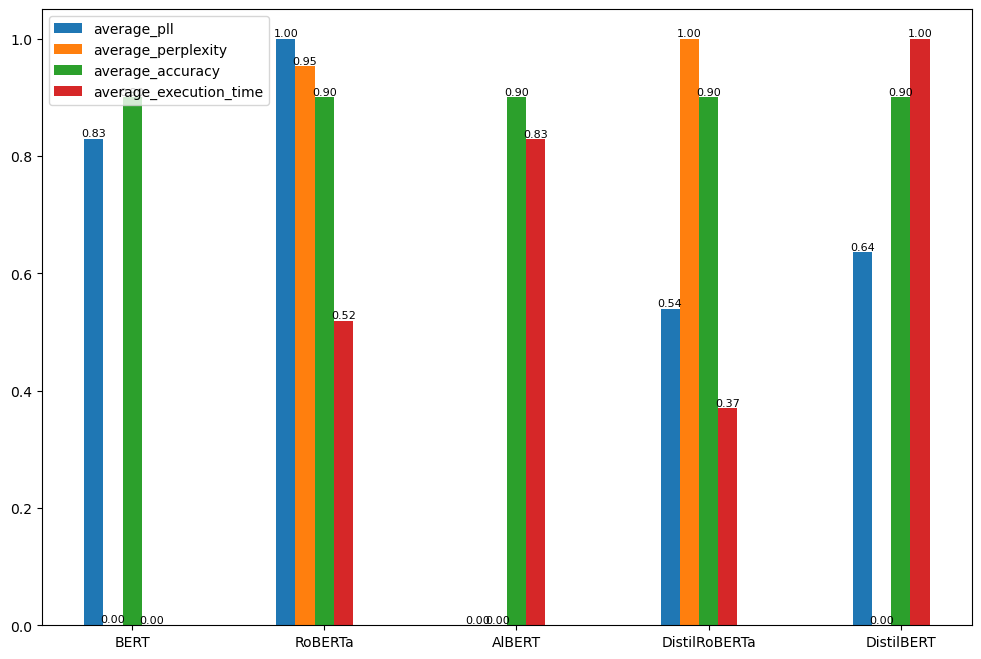

<Figure size 640x480 with 0 Axes>

In [105]:
plot_metrics(normalized_metrics)


## Visualisation

accuracy = [0.44, 0.5, 0.09, 0.39, 0.39]
perplexity = [0.21, 0.19, 0.66, 0.3, 0.32]
execution_time = [0.56, 0.6, 0.48, 0.38, 0.35]

bins = ["BERT", "RoBERTa", "ALBERT", "DistilRoBERTa", "DistilBERT"]

# Visualize the accuracy, perplexity and execution time of each model in a bar chart all in the same plot

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].bar(bins, accuracy)
ax[0].set_title("Accuracy")
ax[1].bar(bins, perplexity)
ax[1].set_title("Perplexity")
ax[2].bar(bins, execution_time)
ax[2].set_title("Execution time (s)")

# add title
fig.suptitle("Performance of the models on a test dataset", fontsize=16)

plt.show()

def remove_all(liste, value):
    while value in liste:
        liste.remove(value)
    return liste

def similarity(word, list_of_words):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get the synsets of the word
    synsets_word = wn.synsets(lemmatizer.lemmatize(word))

    # Calculate the similarity between the word and each word in the list
    similarities = []
    for w in list_of_words:
        synsets_w = wn.synsets(lemmatizer.lemmatize(w))
        max_sim = 0
        for synset_word in synsets_word:
            for synset_w in synsets_w:
                sim = synset_word.path_similarity(synset_w)
                if sim is not None and sim > max_sim:
                    max_sim = sim
        similarities.append(max_sim)

    if word in list_of_words:
        similarities.append(1)

    # Print the list of similarities
    return np.max(similarities)